<a href="https://colab.research.google.com/github/MOOSUNGPARK/education/blob/master/classification_chest_xray2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MOOSUNGPARK/education.git

Cloning into 'education'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 101 (delta 0), reused 0 (delta 0), pack-reused 98
Receiving objects: 100% (101/101), 14.27 MiB | 7.96 MiB/s, done.


# 모듈 불러오기

In [0]:
from keras import applications, optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import *
from skimage.transform import rotate
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import os

# 경로 설정하기

In [0]:
BASE_PATH = r'./education/KH/dataset/classification'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'Open_I_abd_vs_CXRs', 'TRAIN')
VAL_DATA_PATH = os.path.join(BASE_PATH, 'Open_I_abd_vs_CXRs', 'VAL')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'Open_I_abd_vs_CXRs', 'TEST', 'abd2.png')

# 하이퍼 파라미터

하이퍼 파라미터를 이용해 인공지능 모델을 조정합니다.  
주로 사용하는 하이퍼 파라미터는 다음과 같습니다.

In [0]:
IMG_HEIGHT, IMG_WIDTH = (256, 256)
EPOCHS = 10
BATCH_SIZE = 5
LEARNING_RATE = 1e-4 
DECAY_RATE = 0
INIT_FILTERS = 32
ACTIVATION_FN = 'elu' # relu, elu, sigmoid
DROP_RATE = 0.25

# 데이터 불러오기
AI 모델 학습에 사용할 데이터를 불러오겠습니다.  

In [104]:
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_PATH,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    seed=42)
val_generator = val_datagen.flow_from_directory(directory=VAL_DATA_PATH,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary',
                                                shuffle=False,
                                                seed=42)

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


# **AI 모델을 구성하는 레이어 만들기**

AI 모델은 여러 개의 레이어를 쌓아 올려 만듭니다.  
가장 대표적인 레이어 구조인 **CONV-BN-ACT-POOL** 구조를 만들어 보겠습니다.

먼저 데이터가 들어가는 첫 번째 레이어를 만들어 봅시다.

In [0]:
first_layer = Input(shape=(32, 32, 3))

그 다음으로 데이터의 특징을 추출할 Convolution 레이어를 연결하겠습니다.

In [0]:
second_layer = Conv2D(filters=8, kernel_size=(3, 3), activation=None, padding='same')(first_layer)

다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.

In [0]:
third_layer = BatchNormalization()(second_layer)

Batch Normalization 이후 신호를 변환하여 다음 뉴런으로 전달하는 Activation function 레이어를 추가합니다.

In [0]:
fourth_layer = Activation('relu')(third_layer)

다음으로 이미지 사이즈를 줄여주는 Pooling 레이어를 연결합니다.

In [0]:
fifth_layer = MaxPool2D(strides=(2, 2))(fourth_layer)

그 후 모든 뉴런을 일렬로 늘어세우는 Flatten 레이어를 만듭니다.

In [0]:
sixth_layer = Flatten()(fifth_layer)

일렬로 늘어세운 후 이전 계층의 모든 뉴런을 연결해주는 Fully connected(Dense) 레이어를 연결합니다.

In [0]:
seventh_layer = Dense(12, activation = 'relu')(sixth_layer)

Dropout 레이어를 활용해 일부 뉴런들을 무작위로 학습에서 배제하도록 합시다.

In [0]:
eighth_layer = Dropout(0.25)(seventh_layer)

마지막으로 최종 결과물을 출력해주는 레이어를 만들어 줍니다.

In [0]:
final_layer =  Dense(1, activation='sigmoid')(eighth_layer)

지금까지 만든 레이어를 Model 함수에 넣어 연결하면 모델이 완성됩니다.

In [114]:
sample_model = Model(first_layer, final_layer)
sample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 12)                24588     
__________

# **X-ray 이미지 구분하는 AI 모델 만들기**

앞에서 배운 지식을 바탕으로  
모델 구조가 간단하고 준수한 성능을 보이는 VGG16 모델을 직접 만들어보겠습니다.

In [115]:
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

filters = INIT_FILTERS
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(input_layer)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

l = Flatten()(l)
l = Dense(1024, activation = ACTIVATION_FN)(l)
l = Dropout(DROP_RATE)(l)
l = Dense(512, activation = ACTIVATION_FN)(l)
l = Dropout(DROP_RATE)(l)
output_layer = Dense(1, activation='sigmoid')(l)

model= Model(input_layer, output_layer)
model.compile(optimizer=Adam(lr=LEARNING_RATE, 
                             epsilon=1e-8,
                             decay=DECAY_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_58 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
activation_58 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_59 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
activation_59 (Activation)   (None, 256, 256, 32)      0         
__________

# AI 모델 훈련하기

이렇게 준비한 AI 모델을 fit_generator 함수를 이용해 훈련시킬 수 있습니다.

In [116]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n // BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_data=val_generator,
                              validation_steps=val_generator.n // BATCH_SIZE)

Epoch 1/10
13/13 [==============================] - 10s 738ms/step - loss: 2.5994 - acc: 0.6000 - val_loss: 0.0366 - val_acc: 1.0000
Epoch 2/10
13/13 [==============================] - 2s 176ms/step - loss: 0.5078 - acc: 0.8154 - val_loss: 9.3164e-05 - val_acc: 1.0000
Epoch 3/10
13/13 [==============================] - 2s 177ms/step - loss: 0.1367 - acc: 0.9538 - val_loss: 4.7598e-07 - val_acc: 1.0000
Epoch 4/10
13/13 [==============================] - 2s 179ms/step - loss: 0.2477 - acc: 0.9231 - val_loss: 1.6746e-06 - val_acc: 1.0000
Epoch 5/10
13/13 [==============================] - 2s 179ms/step - loss: 0.3023 - acc: 0.8923 - val_loss: 1.6038e-05 - val_acc: 1.0000
Epoch 6/10
13/13 [==============================] - 2s 177ms/step - loss: 0.5296 - acc: 0.8615 - val_loss: 2.4009e-04 - val_acc: 1.0000
Epoch 7/10
13/13 [==============================] - 2s 179ms/step - loss: 0.5193 - acc: 0.8923 - val_loss: 1.6564e-06 - val_acc: 1.0000
Epoch 8/10
13/13 [==============================] -

# 훈련 결과 확인하기

훈련 결과를 한 눈에 확인할 수 있는 그래프를 만들어 보겠습니다.

먼저 그래프의 **y축에 사용할 값**들을 **history 항목**에서 추출해 봅시다.

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

다음으로 그래프의 **x축** 값으로 사용할 **epoch** 을 뽑아 보겠습니다.

In [0]:
epochs = range(len(acc))

값들을 확인해볼까요?

In [119]:
acc

[0.600000011233183,
 0.8153846240960635,
 0.9538461565971375,
 0.9230769276618958,
 0.8923076952879245,
 0.8615384697914124,
 0.892307698726654,
 0.9692307710647583,
 0.9846153855323792,
 1.0]

In [120]:
val_acc

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [121]:
loss

[2.59937462855417,
 0.507815173209215,
 0.13670743503626698,
 0.2476874951125515,
 0.30227214667274893,
 0.5295848066620797,
 0.519303417073703,
 0.04407263982207391,
 0.050570404589122445,
 0.009146436969436204]

In [122]:
val_loss

[0.036567144840958576,
 9.316378498169797e-05,
 4.759759946182385e-07,
 1.674613713475992e-06,
 1.6038419527575343e-05,
 0.00024009461341734095,
 1.6564345344249887e-06,
 6.578972715942655e-06,
 7.983966499836015e-05,
 6.950830105267869e-06]

In [123]:
list(epochs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

이 값들을 이용해 그래프를 만들어 보겠습니다.

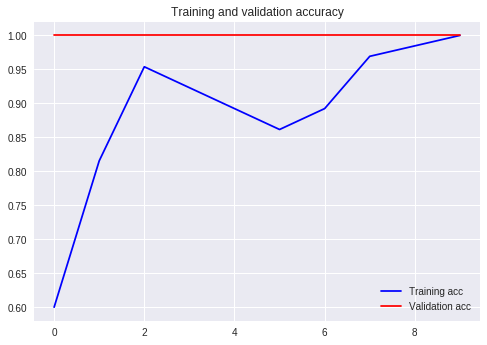

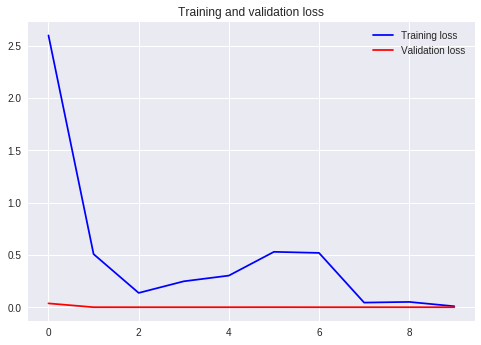

In [124]:
plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 테스트하기

마지막으로 AI 모델이 실제로 X-ray 이미지를 잘 분류하는지 확인해보겠습니다.

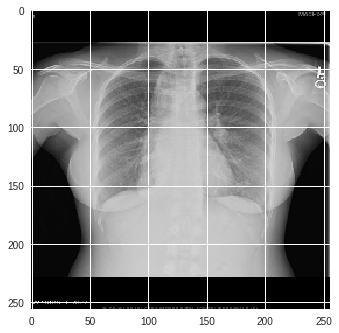

Predicted: Chest X-ray , Score: 0.00065102556


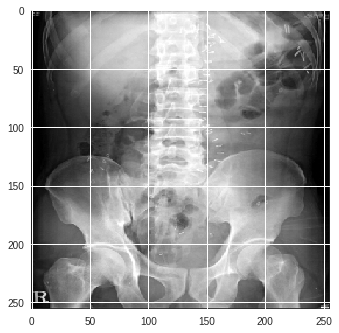

Predicted:  Abd X-ray , Score: 0.9999999


In [126]:
img1_path = './education/KH/dataset/classification/Open_I_abd_vs_CXRs/TEST/chest2.png'
img2_path = './education/KH/dataset/classification/Open_I_abd_vs_CXRs/TEST/abd2.png'

img1 = image.load_img(img1_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img2 = image.load_img(img2_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

plt.imshow(img1)
plt.show()

img1 = image.img_to_array(img1)
img1 /= 255.
img1 = img1[np.newaxis, :, :, :]
score1 = model.predict(img1)
print('Predicted:', 'Chest X-ray' if score1 < 0.5 else 'Abd X-ray', ', Score:', score1[0,0])

plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
img2 /= 255.
img2 = img2[np.newaxis, :, :, :]
score2 = model.predict(img2)
print('Predicted: ', 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray', ', Score:', score2[0,0])